In [1]:
import matplotlib.pylab as plt 
%matplotlib inline
import numpy as np
import rubin_sim.maf_proto as maf
import pandas as pd
import sqlite3
import healpy as hp
import copy

from rubin_sim.data import get_baseline
from os.path import basename


In [2]:
def gen_summary_row(info, summary_name, value):
    summary = copy.copy(info)
    summary["summary_name"] = summary_name
    summary["value"] = value
    return summary

In [3]:
baseline_file = get_baseline()
run_name = basename(baseline_file).replace('.db', '')
con = sqlite3.connect(baseline_file)
# Dataframe is handy for some calcs
df = pd.read_sql("select * from observations where night < 365;", con)
# But mostly want numpy array for speed.
visits_array = df.to_records(index=False)
con.close()

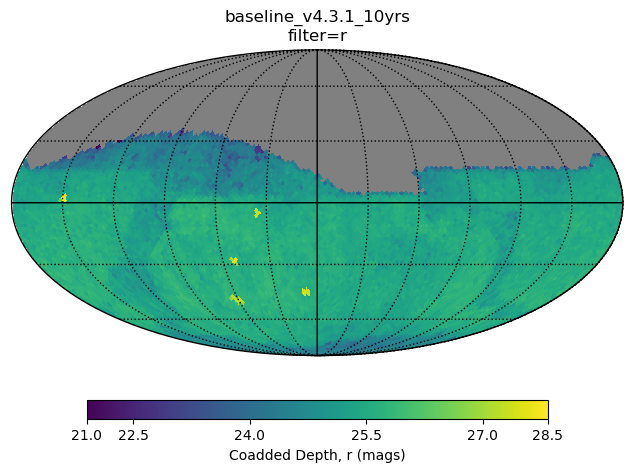

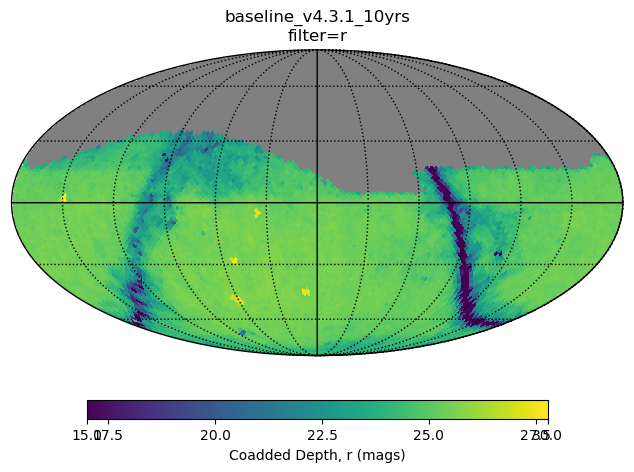

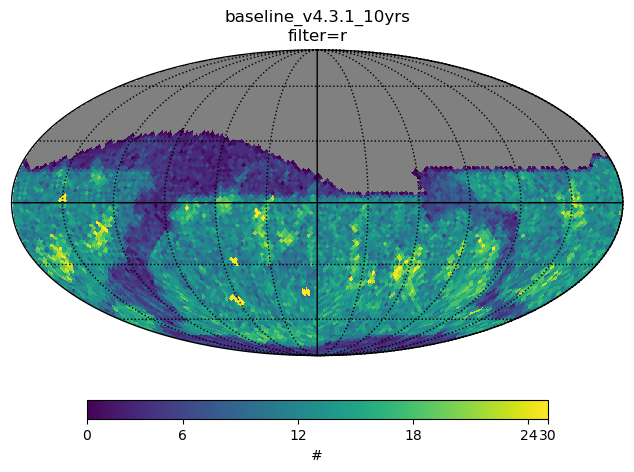

In [4]:
# How one might run multiple calcs on the same slicer
# for speed efficiency.

summary_stats = []
stats_to_run = {"mean": np.nanmean, "median": np.nanmedian}
sl = maf.Slicer(nside=32)

# Things calculated per filter
for i,filtername in enumerate(["r"]): #in enumerate('ugrizy'):
    info = {"run_name": "baseline_v4.3.1_10yrs"}
    info["observations_subset"] =  "filter=%s" % filtername
    # select subset of data
    sub_data = visits_array[np.where(visits_array["filter"] == filtername)[0]]

    # 
    metrics = []
    infos = []
    plot_dicts = []

    # Coadd depth
    metrics.append(maf.CoaddM5Metric(filtername))
    infos.append(copy.copy(info))
    plot_dicts.append({})

    metrics.append(maf.CoaddM5ExtinctionMetric(filtername))
    infos.append(copy.copy(info))
    plot_dicts.append({"min": 17})


    # Number of visits
    metrics.append(maf.CountMetric())
    infos.append(copy.copy(info))
    plot_dicts.append({"min": 1, "max": 25, "cb_params": {"format": "%i", "n_ticks": 4}})

    
    
    # Run the metics through the slicer
    hp_arrays, infos = sl(sub_data, metrics, info=infos)
    
    # For each array we've generated, make a vis, summerize it how we like
    for hp_array, metric, info, plot_dict in zip(hp_arrays, metrics, infos, plot_dicts):
        pm = maf.PlotMoll(info=info)
        fig = pm(hp_array, **plot_dict)
        # XXX--send fig to dir and db at this point if desired
        # Do whatever stats we want on the hp_array
        for stat in stats_to_run:
            summary_stats.append(gen_summary_row(info, stat, stats_to_run[stat](hp_array)))
# Send stats to db


In [5]:
pd.DataFrame(summary_stats)

,run_name,observations_subset,slicer: nside,metric: name,metric: col,metric: unit,summary_name,value
0,baseline_v4.3.1_10yrs,filter=r,32,CoaddDepth,fiveSigmaDepth,"Coadded Depth, r (mags)",mean,25.338822
1,baseline_v4.3.1_10yrs,filter=r,32,CoaddDepth,fiveSigmaDepth,"Coadded Depth, r (mags)",median,25.463813
2,baseline_v4.3.1_10yrs,filter=r,32,CoaddDepthExtinction,fiveSigmaDepth,"Coadded Depth, r (mags)",mean,24.424758
3,baseline_v4.3.1_10yrs,filter=r,32,CoaddDepthExtinction,fiveSigmaDepth,"Coadded Depth, r (mags)",median,25.201667
4,baseline_v4.3.1_10yrs,filter=r,32,Count,night,#,mean,12.172011
5,baseline_v4.3.1_10yrs,filter=r,32,Count,night,#,median,12.000000


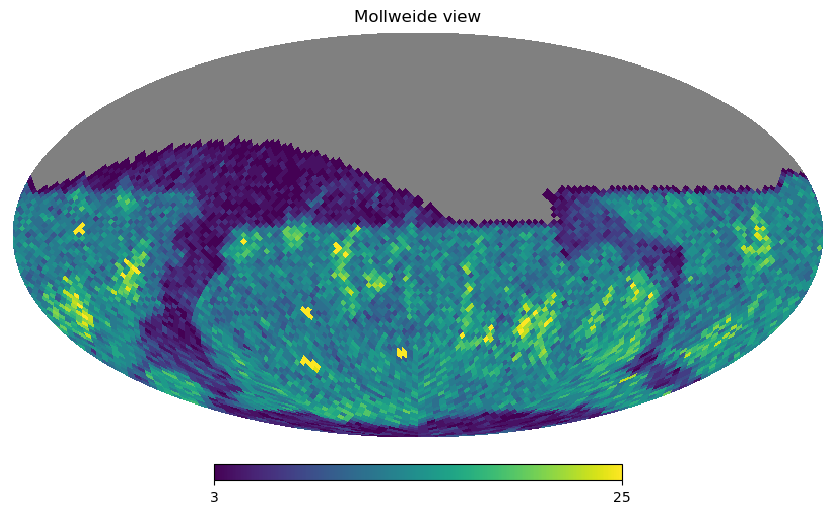

In [6]:
hp.mollview(hp_array, max=25, min=3)